In [1]:
%matplotlib inline

import matplotlib.pyplot as pyplot
import geopandas as gpd
import pandas as pd
import numpy as np
import copy

import shapely.geometry as geom
import shapely.affinity as affine
import shapely.wkt as wkt

from weave_units import WeaveUnit
from tile_units import TileUnit
from tile_map import Tiling

## Normalising tile units
Have to ensure TileUnits consist only of whole elements

### `unit1`

<AxesSubplot:>

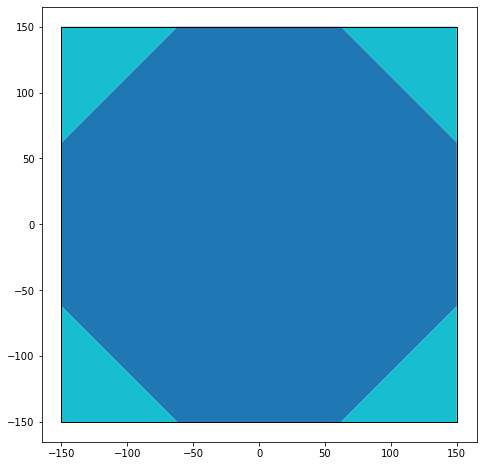

In [2]:
d = 300
unit1 = TileUnit(spacing = d, crs = 2193)

R = d / 2 / np.cos(np.pi / 8)
angles = [np.pi / 8 + a * np.pi / 4 for a in range(8)]

octagon = geom.Polygon([(R * np.cos(a), R * np.sin(a)) for a in angles])
square_fragments = (
    unit1.tile.geometry.difference(
        octagon).explode(index_parts = False, ignore_index = True))

fragments = gpd.GeoSeries([octagon] + list(square_fragments))
fragments = fragments.buffer(-1e-6).buffer(1e-6).apply(
    wkt.dumps, rounding_precision = 6).apply(wkt.loads)
fragments = gpd.GeoSeries([f.simplify(1e-6) for f in list(fragments)])
fragments_gdf = gpd.GeoDataFrame(
    data = {"element_id" : list("abbbb")}, crs = 3857,
    geometry = fragments
)
unit1.elements = fragments_gdf
ax = unit1.elements.plot(column = "element_id", figsize = (8, 8))
unit1.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

### `unit2`

<AxesSubplot:>

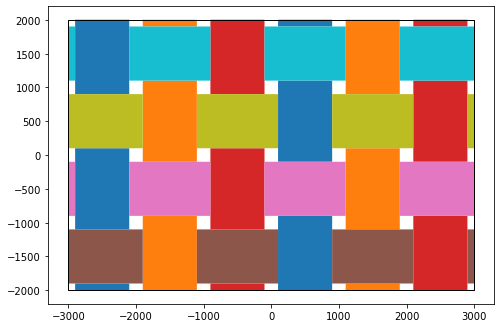

In [10]:
unit2 = WeaveUnit(strands = "abc|defg", crs = 2193, aspect = 0.8, 
                  spacing = 1000)
unit2.elements = unit2.elements.explode(
    index_parts = False, ignore_index = True)

ax = unit2.elements.plot(column = "element_id", figsize = (8, 8))
unit2.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

### `unit3`

<AxesSubplot:>

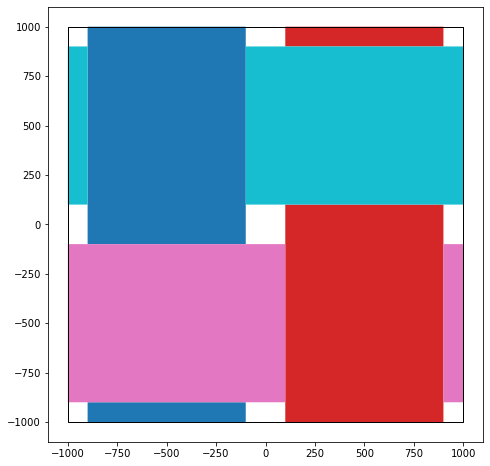

In [11]:
unit3 = WeaveUnit(strands = "ab|cd", crs = 2193, aspect = 0.8, spacing = 1000)
unit3.elements = unit3.elements.explode(
    index_parts = False, ignore_index = True)

ax = unit3.elements.plot(column = "element_id", figsize = (8, 8))
unit3.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

### Get translation vectors

In [12]:
def get_translation_vectors(unit):
    bb = unit.tile.geometry[0].bounds
    w, h = bb[2] - bb[0], bb[3] - bb[1]
    return [(dx, dy) 
            for dx in (-w, 0, w) 
            for dy in (-h, 0, h)
            if (dx == 0 or dy == 0) and dx != dy]
    
t_vecs1 = get_translation_vectors(unit1)
t_vecs2 = get_translation_vectors(unit2)
t_vecs3 = get_translation_vectors(unit3)
t_vecs2

[(-6000.0, 0), (0, -4000.0), (0, 4000.0), (6000.0, 0)]

In [14]:
def select_by_largest_overlap(shapes:list[geom.Polygon], 
                              selecter:geom.Polygon) -> geom.Polygon:
    overlap_areas = [selecter.intersection(s).area for s in shapes]
    max_area = max(overlap_areas)
    idx = overlap_areas.index(max_area)
    return shapes[idx]

def get_shapes_by_attr_val(gdf, attr_name, attr_val):
    return list(gdf[gdf[attr_name] == attr_val].geometry)
    
def translate_gdf(gdf, xoff, yoff):
    result = copy.deepcopy(gdf)
    result.geometry = gdf.geometry.apply(
        affine.translate, xoff = xoff, yoff = yoff)
    return result

def get_upper_rightmost_index(shapes):
    x_plus_y = [s.bounds[2] + s.bounds[3] for s in shapes]
    return x_plus_y.index(max(x_plus_y))


In [18]:
def merge_fragments(
        fragments:list[geom.Polygon],
        vectors:list[tuple],
        tile:geom.Polygon) -> list[geom.Polygon]:
    if len(fragments) == 1:
        return fragments
    changes_made = True
    while changes_made:
        changes_made = False
        for v in vectors:
            next_frags = []
            t_fragments = [affine.translate(f, v[0], v[1]) for f in fragments]
            matches = set()
            for i, f1 in enumerate(fragments):
                for j, f2, in enumerate(t_fragments):
                    if i != j and f1.distance(f2) < 1e-3:
                        matches.add((i, j))
            to_remove = set()
            for i, j in matches:
                f1 = fragments[i]
                f2 = t_fragments[j]
                u1 = f1.union(f2).simplify(1e-6)
                u2 = affine.translate(u1, -v[0], -v[1]).simplify(1e-6)
                if tile.intersection(u1).area > tile.intersection(u2).area:
                    next_frags.append(u1)
                else:
                    next_frags.append(u2)
                changes_made = True
                to_remove.add(i)
                to_remove.add(j)
            fragments = [f for i, f in enumerate(fragments) 
                         if not (i in to_remove)]
            fragments = next_frags + fragments
    return fragments

In [19]:
def normalise_tile_unit(tile_unit, v):
    elements = []
    element_ids = []
    normed_unit = copy.copy(tile_unit)
    ids = list(set(tile_unit.elements.element_id))
    for id in ids:
        fragment_set = list(
            tile_unit.elements[
                tile_unit.elements.element_id == id].geometry)
        merged = merge_fragments(fragment_set, v, tile_unit.tile.geometry[0])
        elements.extend(merged)
        element_ids.extend([id] * len(merged))
    new_elements = gpd.GeoDataFrame(
        data = {"element_id": element_ids}, crs = tile_unit.crs,
        geometry = gpd.GeoSeries(elements)
    )
    normed_unit.elements = new_elements
    return normed_unit


,element_id,geometry
0,d,"POLYGON ((1099.910 900.000, 1099.920 899.998, ..."
1,c,"POLYGON ((99.910 -100.000, 99.920 -100.002, 99..."
2,b,"POLYGON ((100.002 99.920, 100.004 99.929, 100...."
3,a,"POLYGON ((-100.080 1099.998, -100.071 1099.996..."


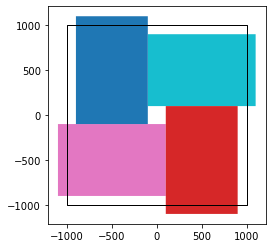

In [22]:
norm_unit = normalise_tile_unit(unit3, t_vecs3)
ax = norm_unit.elements.plot(column = "element_id")
norm_unit.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")
norm_unit.elements